## Splink data linking demo 

In this demo we link two small datasets.  

We assume we have a list of people in one table who we want to find in a larger table.  It is assumed that due to transcription or other errors, there will often not be an exact match.

The larger table contains duplicates, but in this notebook we use the `link_only` setting, so `splink` makes no attempt to deduplicate these records.    Note it is possible to simultaneously link and dedupe using the `link_and_dedupe` setting.

**Important** Where deduplication is not required, `link_only` can provide an important performance boost by dramatically reducing the number of records which need to be compared.

For example, if you wanted to link 10 records to 1,000, then the maximum number of comparisons that need to be made (i.e. with no blocking rules) is 10,000.  If you need to dedupe as well, that number would be n(n-1)/2 = 509,545.

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf = SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   

# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2: Read in the data

The `l` and `r` stand for 'left' and 'right.  It doesn't matter which of the two datasets you choose as the left, performance and results will be the same.

⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [4]:
df_l = spark.read.parquet("data/fake_df_l.parquet")
df_r = spark.read.parquet("data/fake_df_r.parquet")
df_l.show()
df_r.show()

+---------+----------+---------+----------+---------------+--------------------+-----+
|unique_id|first_name|  surname|       dob|           city|               email|group|
+---------+----------+---------+----------+---------------+--------------------+-----+
|        0|    Julia |     null|2015-10-29|         London| hannah88@powers.com|    0|
|        4|      oNah|   Watson|2008-03-23|         Bolton|matthew78@ballard...|    1|
|       13|    Molly |     Bell|2002-01-05|   Peterborough|                null|    2|
|       15| Alexander|  Amelia |1983-05-19|        Glasgow|ic-mpbell@alleale...|    3|
|       20|    Ol vri|  ynnollC|1972-03-08|       Plymouth|derekwilliams@nor...|    4|
|       23|      null| Thompson|1996-03-22|          Leeds|jefferyduke@brown...|    5|
|       27|  Matilda |    Hsrir|1983-04-30|         London| patrcio47@davis.cam|    6|
|       32|    Baxter|    Aria |1992-09-07|         London|christineshepherd...|    7|
|       37|    Wilson| Charlie |1998-09-15|

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "link_only", 
    "max_iterations": 5,
    "blocking_rules": [
        'l.first_name = r.first_name',
        'l.surname = r.surname',
        'l.dob = r.dob'
    ],
    "comparison_columns": [
       {
        "custom_name": "name_inversion",
        "custom_columns_used": ["first_name", "surname", "dob"],
        "case_expression": "CASE WHEN first_name_l = first_name_r AND surname_l = surname_r THEN 2 WHEN first_name_l = surname_r AND surname_l = first_name_r THEN 1 ELSE 0 END",
        "num_levels": 3
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"]
    
}

In words, this setting dictionary says:

- We are performing a data linking task (the other options are `dedupe_only`, or `link_and_dedupe`)
- Rather than generate all possible comparisons (the cartesian product of the input datasets), we are going restrict record comparisons to those generated by at least one of the rules in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm

In [6]:
from splink import Splink

linker = Splink(settings, spark, df_l=df_l, df_r=df_r)
df_e = linker.get_scored_comparisons()

# Later, we will make term frequency adjustments.  
# Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.
df_e.persist()  


INFO:splink.iterate:Iteration 0 complete
INFO:splink.iterate:Iteration 1 complete
INFO:splink.iterate:Iteration 2 complete
INFO:splink.iterate:Iteration 3 complete
INFO:splink.iterate:Iteration 4 complete


DataFrame[match_probability: double, unique_id_l: bigint, unique_id_r: bigint, first_name_l: string, first_name_r: string, surname_l: string, surname_r: string, dob_l: string, dob_r: string, gamma_name_inversion: int, prob_gamma_name_inversion_non_match: double, prob_gamma_name_inversion_match: double, gamma_dob: int, prob_gamma_dob_non_match: double, prob_gamma_dob_match: double, city_l: string, city_r: string, gamma_city: int, prob_gamma_city_non_match: double, prob_gamma_city_match: double, email_l: string, email_r: string, gamma_email: int, prob_gamma_email_non_match: double, prob_gamma_email_match: double, group_l: bigint, group_r: bigint]

## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,gamma_name_inversion,prob_gamma_name_inversion_non_match,prob_gamma_name_inversion_match,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match,group_l,group_r
1304,0.007762,133,881,Harriet,Leo,Jones,Jones,1980-06-23,2019-06-15,0,0.990152,0.587324,0,0.953222,0.145402,London,None,-1,1.000000,1.000000,trobinson@garza.com,tcarr@lewis-kline.com,0,0.986365,0.134991,25,156
243,0.054069,911,403,Tyler,Tyler,Huhgs,None,1971-10-26,2001-07-13,0,0.990152,0.587324,0,0.953222,0.145402,Leeds,None,-1,1.000000,1.000000,dawn74@mckay.com,None,-1,1.000000,1.000000,164,67
178,0.007762,876,302,Isabelle,Isabelle,Carter,Brown,2002-05-17,1979-01-22,0,0.990152,0.587324,0,0.953222,0.145402,Dudley,None,-1,1.000000,1.000000,caldwellmichell@green.biz,josepwatson@smith.com,0,0.986365,0.134991,155,51
373,0.999988,618,621,Arthur,Arthur,Bolton,Bolton,1998-03-07,1998-03-07,2,0.009846,0.264395,1,0.046778,0.854598,Nottingham,Nottingham,1,0.177488,0.779833,milesnine@floras.iz,milesnina@flores.biz,1,0.013635,0.865009,105,105
1406,0.999476,156,159,Enht,Brown,Brow,Ethan,2010-12-22,2010-12-22,0,0.990152,0.587324,1,0.046778,0.854598,Manchester,Manchester,1,0.177488,0.779833,petersbrandon@cox.com,petersbrandon@cox.com,1,0.013635,0.865009,28,28


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

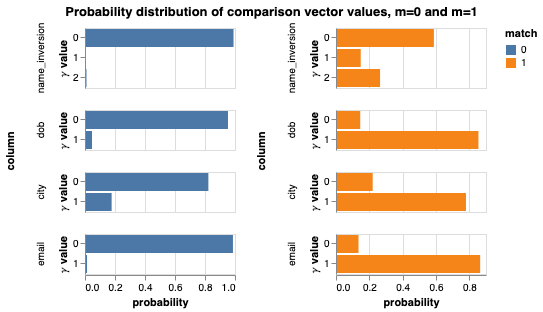

In [8]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

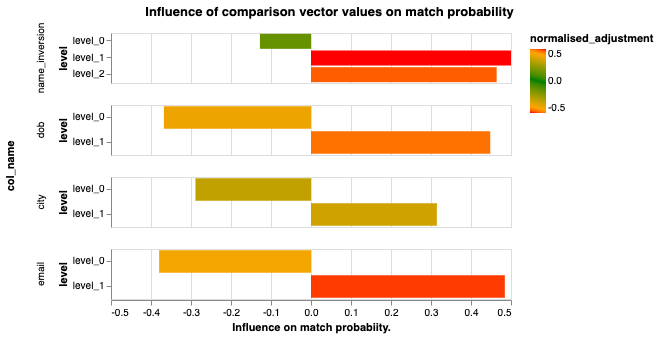

In [9]:
params.adjustment_factor_chart()

In [10]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.38715508580207825

Comparison of name_inversion.  Values are:
name_inversion_l: Arthur , Bolton, 1998-03-07
name_inversion_r: Clara , Bolton, 2013-06-26
Comparison has 3 levels
𝛾 for this comparison = gamma_name_inversion = 0
Amongst matches, P(𝛾 = 0.5873237252235413):
Amongst non matches, P(𝛾 = 0.9901524186134338):
Adjustment factor = p1/(p1 + p2) = 0.3723186100266239
New probability of match (updated belief): 0.27258051351254436

Comparison of dob.  Values are:
dob_l: 1998-03-07
dob_r: 2013-06-26
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 0
Amongst matches, P(𝛾 = 0.14540153741836548):
Amongst non matches, P(𝛾 = 0.9532221555709839):
Adjustment factor = p1/(p1 + p2) = 0.13234880910198527
New probability of match (updated belief): 0.054068513144416824

Comparison of city.  Values are:
city_l: Nottingham
city_r: London
Comparison has 2 levels
𝛾 for this comparison = gamma_city = 0
Amongst matches, P(𝛾 = 0.22016668319702148):


## Step 7: Term frequency adjustments

Splink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [12]:
df_e_adj = linker.make_term_frequency_adjustments(df_e)

/Users/robinlinacre/anaconda3/lib/python3.6/site-packages/splink/term_frequencies.py:141: UserWarning: No term frequency adjustment columns are specified in your settings object.  Returning original df
  "No term frequency adjustment columns are specified in your settings object.  Returning original df"


In [13]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

KeyError: "['tf_adjusted_match_prob'] not in index"